# Single Actuator Simulation

Develop the model for and simulate a single actuator.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

mpl.style.use('mitch-exp')

## State Equations

Let us first define our states:

$x_1 = $ rod position

$x_2 = \dot{x}_1$ (rod velocity)

$x_3 = P_{A}$ (cap-end (A) pressure) 

$x_4 = P_{B}$ (rod-end (B) pressure)

$$\dot{x}_1 = x_2$$

$$\dot{x}_2 = \frac{1}{m_{rod}+m_{load}}(x_3 A_{p,A}-x_4 A_{p,B} - F_L - bx_2)$$

$$\dot{x}_3 = \frac{\beta}{A_{p,A} x_1 + V_{A0}}(Q_{SA}-Q_{AR}-A_{p,A}x_2)$$

$$\dot{x}_4 = \frac{\beta}{V_{B0} + A_{p,B} (s - x_1)}(Q_{SB}-Q_{BR}+A_{p,B}x_2)$$

In [2]:
def get_orifice_area(u, r=0.0012, deadzone=0.4):
    ''' Compute orifice area from valve position (u from [-1, 1]),
        deadzone (as a positive fraction of normalized input),
        and radius r of the ports. See jupyter notebook rotary-valve-gain.ipynb'''
    scale = 2.0 * (1 + (deadzone / (1 - deadzone))) * r
    d = ((np.abs(u) - deadzone) * np.sign(u)) * scale
    if d <= 0:  # if not overlapped
        area = 0
    else:  # overlapped
        theta = np.arccos((r - (d / 2.0)) / r)
        area_s = r**2 * theta
        area_t = r**2 * np.sin(theta) * np.cos(theta)
        area = 2.0 * (area_s - area_t)
    return area

In [3]:
def get_flow_through_orifice(A, Pi, Pj):
    rho = 857  # kg/m^3 ISO grade 32
    Cd = 0.6  # see papers for a value here
    return A * Cd * np.sqrt((2.0 / rho) * np.abs(Pi - Pj)) * np.sign(Pi - Pj)

In [4]:
# Test things so far
A = get_orifice_area(0.7, 0.0012)
Q = get_flow_through_orifice(A, 100, 0)
Q

5.1270484806528759e-07

## Single Actuator Dynamic Model

Develop the dynamics in a function to interface with scipy's ODE solver.

In [5]:
# Set up parameters
pm = {'mrod': 1,  # kg, wild guess
      'mload': 0.0,  # kg
      'ApA': 0.0004,  # m^2
      'ApB': 0.0003,  # m^2
      'VA0': 2e-6,  # m^3
      'VB0': 2e-6,  # m^3
      'stroke': 0.14,  # m, close enough for stick actuator
      'b': 100000,  # N*s/m
      'beta': 1.8e9, # Pa*N / m^2 
      'deadzone': 0.4, # dimless
      'Ps': 4.5e5,
      'Cd': 0.6}  # Pa, based on a 180 N max load

def compute_state_derivatives(t, y, u, Fl, verbose=False):
    ''' Compute state derivatives for a single actuator model
    Args:
        t (float):
        y (array-like):
        u (valve position): valve position on the scale [-1, 1]
        Fl (float): external force opposing cylinder extension
    
    Returns:
        yd = (np.array): derivatives
    '''
    # find open orifices and orifice area 
    area = get_orifice_area(u)
    if (np.abs(u) < pm['deadzone']):
        Qsa = Qar = Qsb = Qbr = 0
    elif u > 0:
        Qsa = get_flow_through_orifice(area, pm['Ps'], y[2])
        Qbr = get_flow_through_orifice(area, y[3], 0)
        Qar = Qsb = 0
    elif u < 0:
        Qar = get_flow_through_orifice(area, y[2], 0)
        Qsb = get_flow_through_orifice(area, pm['Ps'], y[3])
        Qsa = Qbr = 0

    y0d = y[1]
    y1d = (1 / (pm['mrod'])) * (y[2] * pm['ApA'] - y[3] * pm['ApB'] - Fl - pm['b'] * y[1])
    y2d = (pm['beta'] / (pm['ApA'] * y[0] + pm['VA0'])) * (Qsa - Qar - pm['ApA'] * y[1])
    y3d = (pm['beta'] / (pm['VB0'] + pm['ApB'] * (pm['stroke'] - y[0]))) * (Qsb - Qbr + pm['ApB'] * y[1])
    
    if verbose:
        print('Qsa: %.2f \nQar: %.2f \nQsb: %.2f \nQbr: %.2f' % (Qsa, Qar, Qsb, Qbr))
        print('state: %s' % y)
        print('derivatives: %s' % [[y0d, y1d, y2d, y3d]])
    
    return np.array([y0d, y1d, y2d, y3d])

In [12]:
from scipy.integrate import ode
from tqdm import tqdm

In [10]:
def simulate_fixed_input(fd, tf, dt, u):
    ''' Integrate dynamic equations
    Args:
        fd (function handle): first order derivative function
        tf (float): total time
        dt (float): time step
    Returns:
        time (np.array): time series
        yr (np.array): integrated yr
        u (np.array): inputs'''

    yi = [.01, 0, 3.37e5, 4.5e5]
    ti = 0
    s = ode(fd).set_integrator('vode', method='bdf')
    s.set_initial_value(yi, ti)

    s.set_f_params(0.5, 0)

    samples = int((tf - ti) / dt)
    dim = len(yi)
        
    time = np.arange(ti, tf+dt, dt)
    yr = np.zeros((samples + 1, dim))
    i = 0
    
    while s.successful() and s.t < tf:
        s.set_f_params(u[i], 0)
        yr[i] = s.integrate(s.t+dt)
#         print(yr[i])
#         print(compute_state_derivatives(0, yr[i], 0, 0, verbose=True))
#         _ = raw_input(' ')
        i += 1
    
    return time, yr, u

## Simulate ramp

In [24]:
tf = 10
dt = 0.001
samples = int(tf / dt)

u = np.arange(0.3, 0.5, dt/10)
u = np.concatenate((u, np.zeros(samples)))

In [25]:
T, Y, U = simulate_fixed_input(compute_state_derivatives, tf, dt, u)

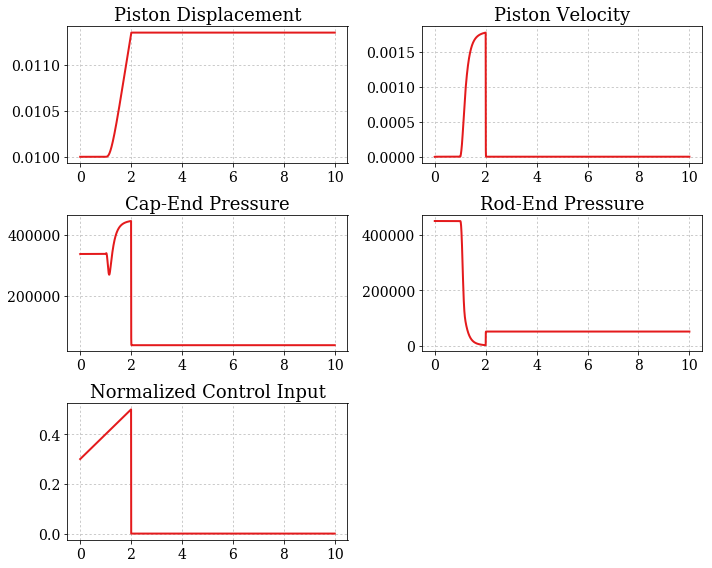

In [26]:
titles = ['Piston Displacement', 'Piston Velocity', 'Cap-End Pressure', 'Rod-End Pressure']
plt.figure(figsize=(10, 8))
for i in range(4):
    plt.subplot(3, 2, i + 1)
    plt.plot(T, Y[:, i])
    plt.title(titles[i])

plt.subplot(3, 2, 5)
plt.plot(T, U[:len(Y)])
plt.title('Normalized Control Input')
plt.tight_layout()

___

## Simulation with PID Controller

Create function for PID controller derivatives.

In [14]:
from ivPID import PID

In [17]:
gains = [1, 1, 1]

PID = PID.PID(*gains)

In [ ]:
# Simulate controller
def simulate_fixed_input(fd, tf, dt, u):
    ''' Integrate dynamic equations
    Args:
        fd (function handle): first order derivative function
        tf (float): total time
        dt (float): time step
    Returns:
        time (np.array): time series
        yr (np.array): integrated yr
        u (np.array): inputs'''

    yi = [.01, 0, 3.37e5, 4.5e5]
    ti = 0
    s = ode(fd).set_integrator('vode', method='bdf')
    s.set_initial_value(yi, ti)

    s.set_f_params(0.5, 0)

    samples = int((tf - ti) / dt)
    dim = len(yi)
        
    time = np.arange(ti, tf+dt, dt)
    yr = np.zeros((samples + 1, dim))
    i = 0
    
    while s.successful() and s.t < tf:
        s.set_f_params(u[i], 0)
        yr[i] = s.integrate(s.t+dt)
#         print(yr[i])
#         print(compute_state_derivatives(0, yr[i], 0, 0, verbose=True))
#         _ = raw_input(' ')
        i += 1
    
    return time, yr, u

In [11]:
a = get_orifice_area(0.5)
a

3.6012444901443452e-07

In [12]:
get_flow_through_orifice(a, 4.5)

TypeError: get_flow_through_orifice() takes exactly 3 arguments (2 given)

In [13]:
yi = [0.01, 0, 3.37e5, 4.5e5]

In [14]:
compute_state_derivatives(0, yi, 0, 0, verbose=True)

Qsa: 0.00 
Qar: 0.00 
Qsb: 0.00 
Qbr: 0.00
state: [0.01, 0, 337000.0, 450000.0]
derivatives: [[0, -0.19999999999998863, 0.0, 0.0]]


[0, -0.19999999999998863, 0.0, 0.0]

In [15]:
pm['ApA'] * 0.01 + pm['VA0']

6e-06

These results are acceptable for now. The parameters may need tuning. Lets move the analysis to MATLAB.

In [16]:
import mat4py

In [23]:
wrap = {'exc': pm}

In [24]:
mat4py.savemat('exc.mat', wrap)

___